# PoseNet for Self-Localization on Apolloscape Dataset

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

In [12]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])


train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)

test_record = 'Record013'
test_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=test_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)



print(train_dataset)
print(val_dataset)
print(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8) # batch_size = 75
test_dataloader = DataLoader(test_dataset, batch_size=8) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Length: 120 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Reco

## Draw Train and Val datasets

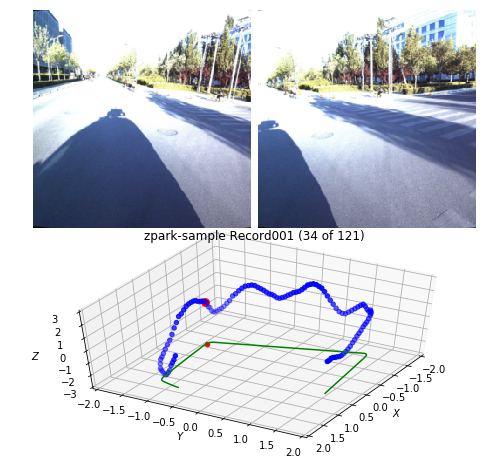

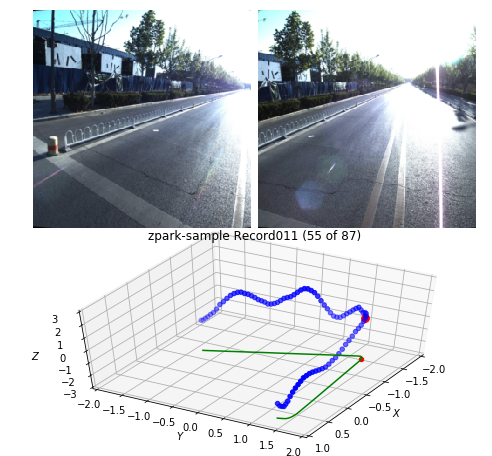

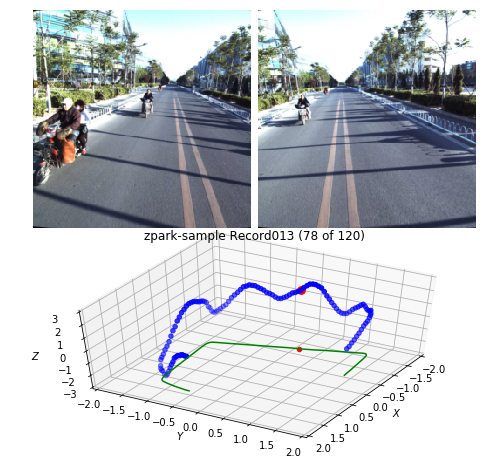

In [13]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()

draw_record(test_dataset)
plt.show()

## Device set up

In [14]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

In [15]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
#     log_freq = 0
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch + 1, max_epoch, idx + 1, len(train_loader),
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch+1, max_epoch, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
#     log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch + 1, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch+1, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [16]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


## Restore from Chekpoint

In [17]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


Loading from checkpoint: _checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar


## Run Training

In [18]:
if 'start_epoch' not in locals():
    start_epoch = 0

n_epochs = start_epoch + 1
print('Training ...')
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0)
#     print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    end = time.time()
    validate(val_dataloader, model, criterion, e, log_freq=0)
#     print('Validation epoch time: {:.3f}'.format(time.time() - end))

    print('Test dataset ...')
    validate(test_dataloader, model, criterion, e, log_freq=1)


Training ...
Epoch: [301/301]	Training Loss: 0.337
Epoch: [301]	Validation Loss: 1.659
Test dataset ...
Val Epoch: 301	Time: 2.057	Data Time: 2.045	Loss: 4.032	Avg Loss: 4.032
Val Epoch: 301	Time: 2.287	Data Time: 2.275	Loss: 5.091	Avg Loss: 4.562
Val Epoch: 301	Time: 2.212	Data Time: 2.199	Loss: 4.266	Avg Loss: 4.463
Val Epoch: 301	Time: 2.221	Data Time: 2.209	Loss: 2.608	Avg Loss: 3.999
Val Epoch: 301	Time: 1.966	Data Time: 1.954	Loss: 1.958	Avg Loss: 3.591
Val Epoch: 301	Time: 2.264	Data Time: 2.251	Loss: 1.949	Avg Loss: 3.317
Val Epoch: 301	Time: 2.248	Data Time: 2.234	Loss: 1.670	Avg Loss: 3.082
Val Epoch: 301	Time: 2.291	Data Time: 2.277	Loss: 1.659	Avg Loss: 2.904
Val Epoch: 301	Time: 2.200	Data Time: 2.186	Loss: 1.115	Avg Loss: 2.705
Val Epoch: 301	Time: 1.962	Data Time: 1.948	Loss: 1.130	Avg Loss: 2.548
Val Epoch: 301	Time: 2.232	Data Time: 2.219	Loss: 1.314	Avg Loss: 2.436
Val Epoch: 301	Time: 2.244	Data Time: 2.230	Loss: 0.779	Avg Loss: 2.298
Val Epoch: 301	Time: 2.246	Data 

In [43]:
# for param_group in optimizer.param_groups:
#     print(param_group['lr'])

## Test Model

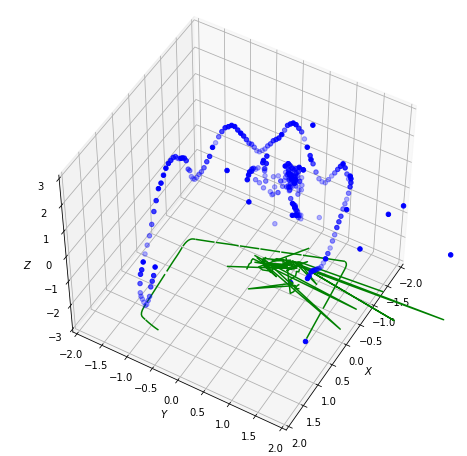

In [41]:
# Test model
# tb_images, tb_poses = next(iter(test_dataloader))
# print('tb_poses = {}'.format(tb_poses))

p_min, p_max, p_mean, p_std = train_dataset.get_poses_params(all_records=True)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
ax.view_init(50, 30)


ax.set_xlim(int(p_min[0] - 1), int(p_max[0] + 1))
ax.set_ylim(int(p_min[1] - 1), int(p_max[1] + 1))
ax.set_zlim(int(p_min[2] - 1), int(p_max[2] + 1))

for idx, (tb_images, tb_poses) in enumerate(train_dataloader):
    tb_images = [x.to(device) for x in tb_images]
    output = model(tb_images)
#     print('output = {}'.format(output))

    # detach
    output = [x.cpu().detach().numpy() for x in output]

#     ax.scatter(output[0][:, 0], output[0][:, 1], output[0][:, 2], c='b')
    
    draw_poses(ax, output[0][:, :3], proj=True, proj_z=int(p_min[2] - 1))
    
    draw_poses(ax, tb_poses[0][:, :3], proj=True, proj_z=int(p_min[2] - 1))
    
    
#     ax.scatter(tb_poses[0][:, 0], tb_poses[0][:, 1], tb_poses[0][:, 2], c='r')

plt.show()

## Save Model Checkpoint

In [46]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001', n_epochs)
    

'_checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar'